In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

[Learn the Basics](intro.html) \|\|
[Quickstart](quickstart_tutorial.html) \|\|
[Tensors](tensorqs_tutorial.html) \|\| [Datasets &
DataLoaders](data_tutorial.html) \|\|
[Transforms](transforms_tutorial.html) \|\| **Build Model** \|\|
[Autograd](autogradqs_tutorial.html) \|\|
[Optimization](optimization_tutorial.html) \|\| [Save & Load
Model](saveloadrun_tutorial.html)

Build the Neural Network
========================

Neural networks comprise of layers/modules that perform operations on
data. The [torch.nn](https://pytorch.org/docs/stable/nn.html) namespace
provides all the building blocks you need to build your own neural
network. Every module in PyTorch subclasses the
[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
A neural network is a module itself that consists of other modules
(layers). This nested structure allows for building and managing complex
architectures easily.

In the following sections, we\'ll build a neural network to classify
images in the FashionMNIST dataset.


In [2]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Get Device for Training
=======================

We want to be able to train our model on an
[accelerator](https://pytorch.org/docs/stable/torch.html#accelerators)
such as CUDA, MPS, MTIA, or XPU. If the current accelerator is
available, we will use it. Otherwise, we use the CPU.


In [3]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

AttributeError: module 'torch' has no attribute 'accelerator'

Define the Class
================

We define our neural network by subclassing `nn.Module`, and initialize
the neural network layers in `__init__`. Every `nn.Module` subclass
implements the operations on input data in the `forward` method.


In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We create an instance of `NeuralNetwork`, and move it to the `device`,
and print its structure.


In [8]:
device='cpu'
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model, we pass it the input data. This executes the model\'s
`forward`, along with some [background
operations](https://github.com/pytorch/pytorch/blob/270111b7b611d174967ed204776985cefca9c144/torch/nn/modules/module.py#L866).
Do not call `model.forward()` directly!

Calling the model on the input returns a 2-dimensional tensor with dim=0
corresponding to each output of 10 raw predicted values for each class,
and dim=1 corresponding to the individual values of each output. We get
the prediction probabilities by passing it through an instance of the
`nn.Softmax` module.


In [9]:

X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([7])


------------------------------------------------------------------------


Model Layers
============

Let\'s break down the layers in the FashionMNIST model. To illustrate
it, we will take a sample minibatch of 3 images of size 28x28 and see
what happens to it as we pass it through the network.


In [10]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


nn.Flatten
==========

We initialize the
[nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)
layer to convert each 2D 28x28 image into a contiguous array of 784
pixel values ( the minibatch dimension (at dim=0) is maintained).


In [11]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


nn.Linear
=========

The [linear
layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
is a module that applies a linear transformation on the input using its
stored weights and biases.


In [12]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


nn.ReLU
=======

Non-linear activations are what create the complex mappings between the
model\'s inputs and outputs. They are applied after linear
transformations to introduce *nonlinearity*, helping neural networks
learn a wide variety of phenomena.

In this model, we use
[nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
between our linear layers, but there\'s other activations to introduce
non-linearity in your model.


In [13]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[-0.2307,  0.1570, -0.2982,  0.3354,  0.4356,  0.2854,  0.0040, -0.0279,
         -0.7456, -0.2665,  0.6230, -0.4541, -0.1102,  0.7716,  0.2887, -0.4283,
          0.0268, -0.5610, -0.1821, -0.0404],
        [-0.6237,  0.2685, -0.8489,  0.0874,  0.2343,  0.1491, -0.3478, -0.0739,
         -0.3819, -0.1738,  0.3671, -0.2961,  0.0247,  0.5187,  0.7250, -0.0904,
         -0.4615, -0.3035, -0.2003, -0.0345],
        [-0.4109, -0.0928, -0.4650,  0.2140,  0.3726, -0.2274, -0.0805, -0.0727,
         -0.7255, -0.1704,  0.2759, -0.2649,  0.2591,  0.7672,  0.3610, -0.3974,
         -0.4317, -0.3481, -0.3333,  0.0833]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.1570, 0.0000, 0.3354, 0.4356, 0.2854, 0.0040, 0.0000, 0.0000,
         0.0000, 0.6230, 0.0000, 0.0000, 0.7716, 0.2887, 0.0000, 0.0268, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.2685, 0.0000, 0.0874, 0.2343, 0.1491, 0.0000, 0.0000, 0.0000,
         0.0000, 0.3671, 0.0000, 0.0247, 0.5187, 0.72

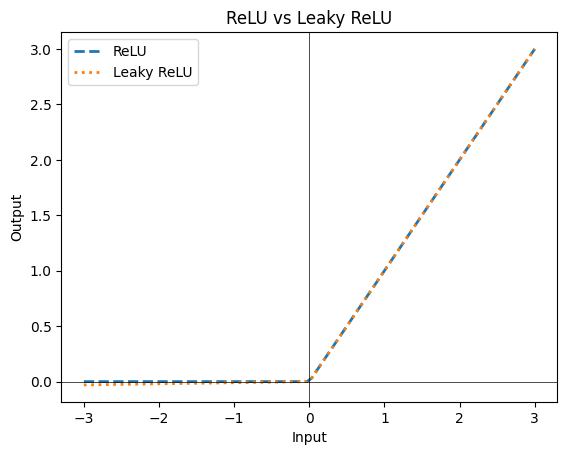

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-3, 3, 100)
relu = np.maximum(0, x)  # ReLU 计算公式
leaky_relu = np.where(x > 0, x, 0.01 * x)  # Leaky ReLU

plt.plot(x, relu, label="ReLU", linestyle="--", linewidth=2)
plt.plot(x, leaky_relu, label="Leaky ReLU", linestyle=":", linewidth=2)
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.legend()
plt.xlabel("Input")
plt.ylabel("Output")
plt.title("ReLU vs Leaky ReLU")
plt.show()



nn.Sequential
=============

[nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
is an ordered container of modules. The data is passed through all the
modules in the same order as defined. You can use sequential containers
to put together a quick network like `seq_modules`.


In [17]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)
print(logits)
print(logits.size())

tensor([[-0.1612, -0.0128, -0.2282,  0.0553, -0.0959,  0.3103,  0.0853,  0.2858,
         -0.1562,  0.0166],
        [-0.0402, -0.0753, -0.2156,  0.0999, -0.2136,  0.2883,  0.0493,  0.1975,
         -0.2522, -0.1026],
        [-0.1314, -0.0944, -0.3573,  0.0046, -0.0794,  0.3474,  0.1842,  0.3791,
         -0.2865,  0.0565]], grad_fn=<AddmmBackward0>)
torch.Size([3, 10])


nn.Softmax
==========

The last linear layer of the neural network returns [logits]{.title-ref}
- raw values in \[-infty, infty\] - which are passed to the
[nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)
module. The logits are scaled to values \[0, 1\] representing the
model\'s predicted probabilities for each class. `dim` parameter
indicates the dimension along which the values must sum to 1.


In [19]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)
print(pred_probab)
print(pred_probab.argmax())

tensor([[0.0830, 0.0963, 0.0776, 0.1031, 0.0886, 0.1330, 0.1062, 0.1298, 0.0834,
         0.0991],
        [0.0971, 0.0938, 0.0815, 0.1117, 0.0817, 0.1349, 0.1062, 0.1232, 0.0786,
         0.0913],
        [0.0851, 0.0883, 0.0679, 0.0975, 0.0897, 0.1374, 0.1167, 0.1418, 0.0729,
         0.1027]], grad_fn=<SoftmaxBackward0>)
tensor(27)


Model Parameters
================

Many layers inside a neural network are *parameterized*, i.e. have
associated weights and biases that are optimized during training.
Subclassing `nn.Module` automatically tracks all fields defined inside
your model object, and makes all parameters accessible using your
model\'s `parameters()` or `named_parameters()` methods.

In this example, we iterate over each parameter, and print its size and
a preview of its values.


In [21]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0096,  0.0160,  0.0208,  ...,  0.0169, -0.0060,  0.0236],
        [ 0.0218, -0.0268, -0.0308,  ...,  0.0257, -0.0300,  0.0259]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([ 0.0181, -0.0158], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0360, -0.0341,  0.0265,  ...,  0.0072, -0.0168,  0.0325],
        [ 0.0392,  0.0354, -0.0391,  ..., -0.0330, -0.0062,  0.0305]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# 选择设备（CUDA 可用时使用 GPU，否则使用 CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 定义简单的神经网络
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(2, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 创建模型，并移动到 GPU
model = SimpleNN().to(device)

# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 生成输入数据和标签，并移动到 GPU
x = torch.rand(4, 3).to(device)  # 输入数据
y_true = torch.tensor([0, 1, 0, 1]).to(device)  # 真实标签

# 训练循环
for epoch in range(10):
    optimizer.zero_grad()  # 清空梯度
    y_pred = model(x)  # 前向传播
    loss = loss_fn(y_pred, y_true)  # 计算损失
    loss.backward()  # 计算梯度
    optimizer.step()  # 更新参数

    print(f"Epoch {epoch}, Loss: {loss.item()}")


Using device: cpu
Epoch 0, Loss: 0.7539452314376831
Epoch 1, Loss: 0.7532259821891785
Epoch 2, Loss: 0.7525136470794678
Epoch 3, Loss: 0.7518079876899719
Epoch 4, Loss: 0.7511091828346252
Epoch 5, Loss: 0.7504169940948486
Epoch 6, Loss: 0.7497313022613525
Epoch 7, Loss: 0.7490522861480713
Epoch 8, Loss: 0.748379647731781
Epoch 9, Loss: 0.7477132081985474


------------------------------------------------------------------------


Further Reading
===============

-   [torch.nn API](https://pytorch.org/docs/stable/nn.html)
